# Operações de mutação
Após executar o notebook de **classificação**, podemos realizar operações de mutação no texto para verificar qual impacto elas têm na classificação dos níveis de dificuldade do texto.

In [1]:
import pandas as pd
import numpy as np
import random

random.seed(8)

## Leitura dos dados

In [2]:
# Read dataset into Pandas DataFrame
df = pd.read_csv('dataset.csv', index_col='id')
df.head()

,text,label
id,,
207_765,"nada impede, no entanto, que sejam substituído...",1
232_790,e muitas palavras faladas por esses povos fora...,1
39_347,"sete séculos antes do nascimento de cristo, o ...",1
48_379,voar sempre foi um dos grandes sonhos da human...,1
73_629,"para os bolsos de seus senhores, é claro. você...",1


In [3]:
# download nltk required packages
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/caio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/caio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
import pickle
import os

path = 'pickle'
if os.path.isdir(path):
    # Read the Naive Bayes classifier from pickle
    with open(f'{path}/pipeline_NB.pickle', 'rb') as nb_pickle:
        pipeNB = pickle.load(nb_pickle)

    # Read the SVC classifier from pickle
    with open(f'{path}/pipeline_SVC.pickle', 'rb') as svc_pickle:
        pipeSVC = pickle.load(svc_pickle)

## Troca de palavras

In [5]:
from nltk.corpus import wordnet 

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word, lang='por'): 
        for l in syn.lemmas(lang='por'): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklçzxcvbnmáàãâéêíóõôúü'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [6]:
def synonym_replacement(words, n):
    from stop_words import get_stop_words
    if n <= 0: # no word to replace, return the original text
        return words
        
    words = words.split()
    stop_words = get_stop_words('portuguese')
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

### Teste com um texto exemplo

In [7]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

In [33]:
# Retrieve the last text from the test set
text = X_test.iloc[-1]
print(text)

a prostituição é uma atividade antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de profissional porque têm dificuldades de conseguir parceiros sexuais ou então para procurar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, geralmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um real sentimento entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, supostamente denotando excitação sexual. porém estudos recentes indicam que, na maioria das vezes, tal comportamento não reflete real excitação sexual, mas apenas o desejo de estimular sexualmente o parceiro. existem uma diferenciação no papel de cada gênero sexual dentro da relação afetiva. estudos indicam, por exemplo, que um casamento tem mais chances de ser bem-sucedido se a mulher for mais inteligente, mais jovem ou mais feliz com a relação que o ho

In [34]:
sentence = synonym_replacement(text, len(text.split()) * 0.5)
print(sentence)

a prostituição é uma ato antiquíssima e que constantemente encontra espaço nas sociedades. em geral, os clientes procuram esse jaez de quem pratica uma profissão porque causa têm dificuldades de ser bem sucedidos parceiros sexuais ou época para investigar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, normalmente é uma pertinência desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um genuíno impressão entre os parceiros. durante a pertinência sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, alegada denotando estremecimento sexual. de qualquer jeito estudos recentes indicam que, na ascendência das vezes, assim maneira não reflete genuíno estremecimento sexual, mas exclusive o deseo de excitar sexualmente o parceiro. existem uma diferenciação biologia no personagem de próximo a subespécie sexual adentro da pertinência afetiva. estudos indicam, por exemplo, que um noivado tem mais chance de bicho bem 

In [10]:
# Create list of texts to predict
X_eval = [text]
label_NB = pipeNB.predict(X_eval)
label_SVC = pipeSVC.predict(X_eval)

print(f'Naive Bayes label: {label_NB}')
print(f'SVC label: {label_SVC}')
print(f'Correct label: {y_test[-1]}')

Naive Bayes label: [3]
SVC label: [3]
Correct label: 3


### Avaliação da influência da troca de palavras

In [25]:
from sklearn.metrics import accuracy_score

In [30]:
accuracy_NB = []
accuracy_SVC = []

percentage_range = np.arange(0, 1, step=0.05)
for percent in percentage_range:
    X_test_syn  = [synonym_replacement(text, len(text.split()) * percent) for text in X_test]
    
    predictions_NB = pipeNB.predict(X_test_syn)
    accuracy_NB.append(accuracy_score(y_test, predictions_NB))
    predictions_SVC = pipeSVC.predict(X_test_syn)
    accuracy_SVC.append(accuracy_score(y_test, predictions_SVC))

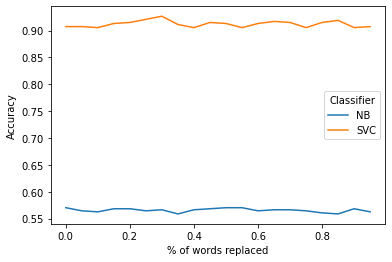

In [35]:
import matplotlib.pyplot as plt

plt.plot(percentage_range, accuracy_NB, label='NB')
plt.plot(percentage_range, accuracy_SVC, label='SVC')
plt.ylabel('Accuracy')
plt.xlabel('% of words replaced')
plt.legend(title='Classifier')
plt.savefig('figures/accuracy_replacement.png', dpi=200)
plt.show()

## Paráfrase

In [18]:
!pip install deep-translator

In [19]:
from deep_translator import GoogleTranslator

In [20]:
supported_languages = GoogleTranslator.get_supported_languages()
print(f'Number of supported languages: {len(supported_languages)}')
print(supported_languages)

Number of supported languages: 109
['afrikaans', 'albanian', 'amharic', 'arabic', 'armenian', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'bosnian', 'bulgarian', 'catalan', 'cebuano', 'chichewa', 'chinese (simplified)', 'chinese (traditional)', 'corsican', 'croatian', 'czech', 'danish', 'dutch', 'english', 'esperanto', 'estonian', 'filipino', 'finnish', 'french', 'frisian', 'galician', 'georgian', 'german', 'greek', 'gujarati', 'haitian creole', 'hausa', 'hawaiian', 'hebrew', 'hindi', 'hmong', 'hungarian', 'icelandic', 'igbo', 'indonesian', 'irish', 'italian', 'japanese', 'javanese', 'kannada', 'kazakh', 'khmer', 'kinyarwanda', 'korean', 'kurdish', 'kyrgyz', 'lao', 'latin', 'latvian', 'lithuanian', 'luxembourgish', 'macedonian', 'malagasy', 'malay', 'malayalam', 'maltese', 'maori', 'marathi', 'mongolian', 'myanmar', 'nepali', 'norwegian', 'odia', 'pashto', 'persian', 'polish', 'portuguese', 'punjabi', 'romanian', 'russian', 'samoan', 'scots gaelic', 'serbian', 'sesotho', 'shona',

In [21]:
translated = GoogleTranslator(source='pt', target='en').translate(text)
back_translated = GoogleTranslator(source='en', target='pt').translate(translated)

print(f'Original Text [pt]: {text}\n')
print(f'Translated Text [en]: {translated}\n')
print(f'Back Translation [pt]: {back_translated}')

Original Text [pt]: a prostituição é uma atividade antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de profissional porque têm dificuldades de conseguir parceiros sexuais ou então para procurar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, geralmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um real sentimento entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, supostamente denotando excitação sexual. porém estudos recentes indicam que, na maioria das vezes, tal comportamento não reflete real excitação sexual, mas apenas o desejo de estimular sexualmente o parceiro. existem uma diferenciação no papel de cada gênero sexual dentro da relação afetiva. estudos indicam, por exemplo, que um casamento tem mais chances de ser bem-sucedido se a mulher for mais inteligente, mais jovem ou mais feliz co

In [22]:
# medir similaridade entre os textos